In [163]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.integrate import odeint
import lmfit

In [164]:
sns.set()
%matplotlib inline

In [165]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [166]:
%autoreload 2

In [167]:
from sir_models.seir import SEIR

# Load data

In [168]:
df = pd.read_csv('data/data.csv', sep=';')

In [169]:
df.columns = ['date', 'region', 'total_infected', 'total_recovered', 'total_dead', 'deaths_per_day', 'infected_per_day', 'recovered_per_day']
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')

df['infected'] = df['total_infected'] - df['total_recovered'] - df['total_dead']

In [170]:
df = df[df.region == 'Москва'].reset_index()
#df = df.groupby('date').sum().reset_index()

In [171]:
df.head()

,index,date,region,total_infected,total_recovered,total_dead,deaths_per_day,infected_per_day,recovered_per_day,infected
0,40,2020-03-12,Москва,21,0,0,0,21,0,21
1,122,2020-03-13,Москва,26,0,0,0,5,0,26
2,204,2020-03-14,Москва,35,0,0,0,9,0,35
3,286,2020-03-15,Москва,35,1,0,0,0,1,34
4,368,2020-03-16,Москва,53,1,0,0,18,0,52


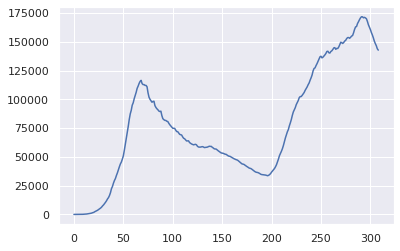

In [172]:
df['infected'].plot()

In [173]:
df_smoothed = df.drop(columns=['region']).rolling(3).mean()
df_smoothed['date'] = df['date']
df_smoothed.head(10)

,index,total_infected,total_recovered,total_dead,deaths_per_day,infected_per_day,recovered_per_day,infected,date
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-12
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-13
2,122.000000,27.333333,0.000000,0.0,0.0,11.666667,0.000000,27.333333,2020-03-14
3,204.000000,32.000000,0.333333,0.0,0.0,4.666667,0.333333,31.666667,2020-03-15
4,286.000000,41.000000,0.666667,0.0,0.0,9.000000,0.333333,40.333333,2020-03-16
5,368.000000,47.666667,1.000000,0.0,0.0,6.666667,0.333333,46.666667,2020-03-17
6,450.666667,64.666667,1.000000,0.0,0.0,17.000000,0.000000,63.666667,2020-03-18
7,534.333333,79.666667,1.000000,0.0,0.0,15.000000,0.000000,78.666667,2020-03-19
8,619.000000,105.000000,2.333333,0.0,0.0,25.333333,1.333333,102.666667,2020-03-20
9,704.000000,122.000000,4.666667,0.0,0.0,17.000000,2.333333,117.333333,2020-03-21


Text(0.5, 1.0, 'Active infected')

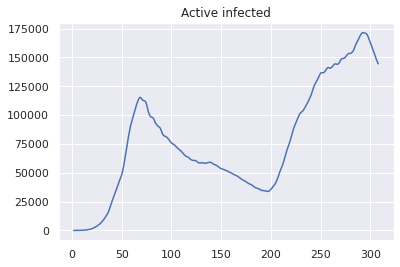

In [174]:
df_smoothed.infected.plot()
plt.title('Active infected')

Text(0.5, 1.0, 'Total infected')

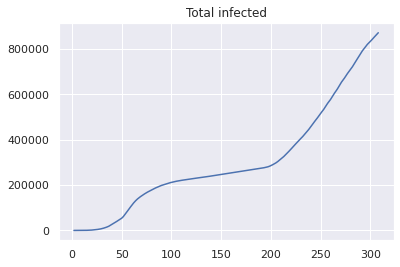

In [175]:
df_smoothed.total_infected.plot()
plt.title('Total infected')

Text(0.5, 1.0, 'Total dead')

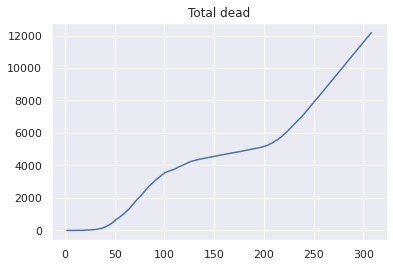

In [176]:
df_smoothed.total_dead.plot()
plt.title('Total dead')

In [177]:
df = df_smoothed.dropna().reset_index(drop=True)

# Set global params

In [178]:
population = 12_000_000

# SIR first peak

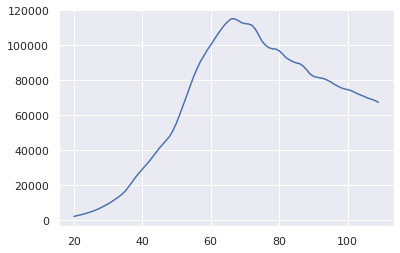

In [179]:
df[20:110]['infected'].plot()

In [180]:
df[20:110]['infected']

20      2266.666667
21      2729.000000
22      3179.000000
23      3683.666667
24      4281.000000
           ...     
105    70748.000000
106    69851.333333
107    69275.000000
108    68544.333333
109    67526.666667
Name: infected, Length: 90, dtype: float64

In [181]:
model = SEIR(population)

subset = df[20:110]
model.fit(subset)

result = model.fit_result_
#result.plot_fit(datafmt="-");
result

In [182]:
R0 = result.params['beta']/result.params['gamma']
R0

6.201967609432449

In [183]:
S, E, I, R, D = model.predict_train()

In [184]:
R[0], E[0], I[0], D[0]

(0.0, 0.0, 2266.6666666666665, 0.0)

In [185]:
R[20]

52855.84557462673

In [186]:
I[:20].cumsum()[-1]

333205.63608118217

In [187]:
I[:20].cumsum()[-1]/R[20]

6.304045133678391

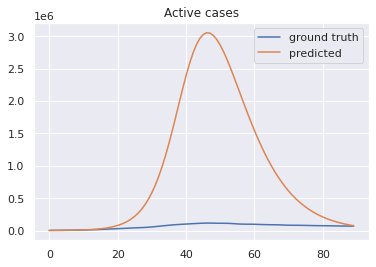

In [188]:
plt.figure()
x = np.arange(len(subset))
plt.plot(x, subset['infected'], label='ground truth')
plt.plot(x, I, label='predicted')
plt.legend()
plt.title('Active cases')
plt.show()

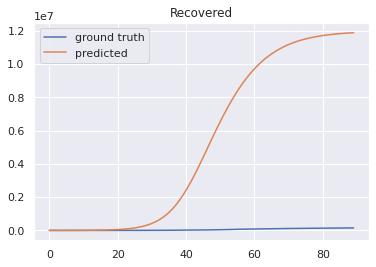

In [189]:
plt.figure()
x = np.arange(len(subset))
plt.plot(x, subset['total_recovered'], label='ground truth')
plt.plot(x, R, label='predicted')
plt.legend()
plt.title('Recovered')
plt.show()

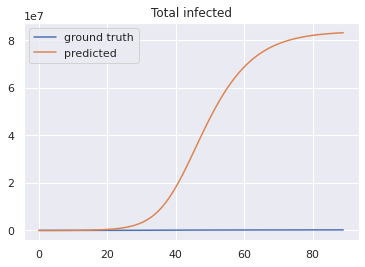

In [190]:
plt.figure()
x = np.arange(len(subset))
plt.plot(x, subset['total_infected'], label='ground truth')
plt.plot(x, I.cumsum(), label='predicted')
plt.legend()
plt.title('Total infected')
plt.show()

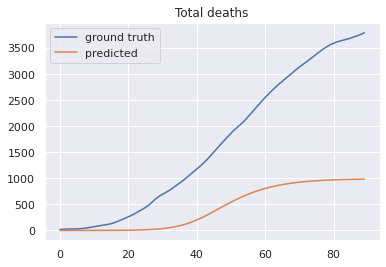

In [191]:
plt.figure()
x = np.arange(len(subset))
plt.plot(x, subset['total_dead'], label='ground truth')
plt.plot(x, D, label='predicted')
plt.legend()
plt.title('Total deaths')
plt.show()

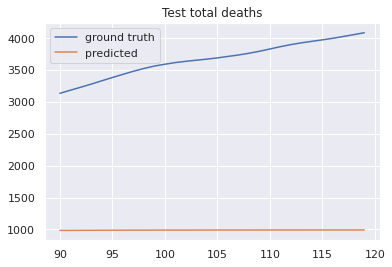

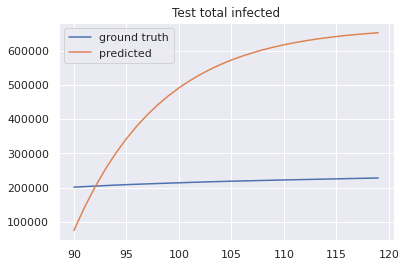

In [192]:
test_subset = df[len(subset):len(subset)+30]

test_t = np.arange(len(subset), len(subset)+len(test_subset))
S, E, I, R, D = model.predict_test(test_t)

plt.figure()
plt.plot(test_t, test_subset['total_dead'], label='ground truth')
plt.plot(test_t, D, label='predicted')
plt.legend()
plt.title('Test total deaths')
plt.show()

plt.figure()
plt.plot(test_t, test_subset['total_infected'], label='ground truth')
plt.plot(test_t, I.cumsum(), label='predicted')
plt.legend()
plt.title('Test total infected')
plt.show()


# SIR full

In [193]:
model = SEIR(population)
subset = df
model.fit(subset)

S, E, I, R, D = model.predict_train()

result = model.fit_result_
R0 = result.params['beta']/result.params['gamma']
R0

2.100002763542506

In [194]:
result

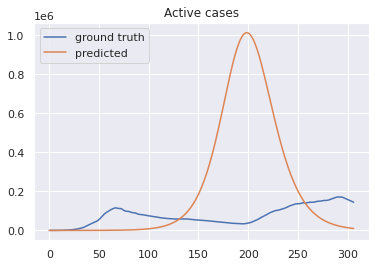

In [195]:
plt.figure()
x = np.arange(len(subset))
plt.plot(x, subset['infected'], label='ground truth')
plt.plot(x, I, label='predicted')
plt.legend()
plt.title('Active cases')
plt.show()

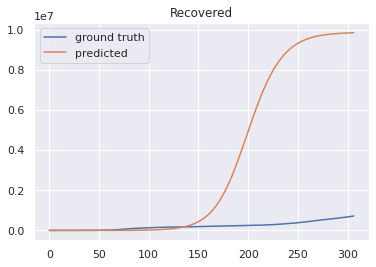

In [196]:
plt.figure()
x = np.arange(len(subset))
plt.plot(x, subset['total_recovered'], label='ground truth')
plt.plot(x, R, label='predicted')
plt.legend()
plt.title('Recovered')
plt.show()

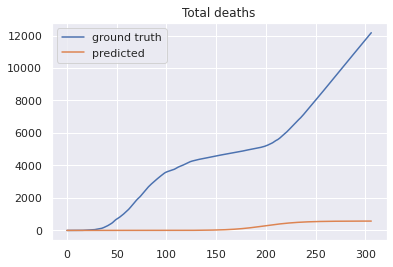

In [197]:
plt.figure()
x = np.arange(len(subset))
plt.plot(x, subset['total_dead'], label='ground truth')
plt.plot(x, D, label='predicted')
plt.legend()
plt.title('Total deaths')
plt.show()

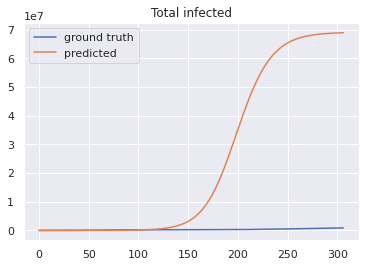

In [198]:
plt.figure()
x = np.arange(len(subset))
plt.plot(x, subset['total_infected'], label='ground truth')
plt.plot(x, I.cumsum(), label='predicted')
plt.legend()
plt.title('Total infected')
plt.show()

# Evaluate predictive ability

In [199]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, r2_score

In [200]:
tscv = TimeSeriesSplit(max_train_size=100, n_splits=10)

In [201]:
maes = []
params = []
for i, (train_index, test_index) in enumerate(tscv.split(range(len(df)))):
    print('Fold', i)
    print(len(train_index), len(test_index))
    train_subset = df.iloc[train_index]
    test_subset = df.iloc[test_index]
    
    model = SIROneStain(population)
    model.fit(train_subset)

    result = model.fit_result_
    params.append(result.params)
    #result.plot_fit(datafmt="-")
    
    train_S, train_I, train_R, train_D = model.predict_train()
    S, I, R, D = model.predict_test(test_index)
    
    train_mae = mean_absolute_error(train_subset['total_dead'], train_D)
    
    plt.figure(figsize=(15, 7))
    plt.subplot(1, 3, 1)
    plt.plot(train_index, train_subset['total_dead'], 'o', label='deaths ground truth', marker='o', color='red')
    plt.plot(train_index, train_D, label='deaths predicted', color='black')
    plt.title(f'Train deaths, MAE: {train_mae:0.2f}')
    plt.legend()
    plt.subplot(1, 3, 2)
    plt.plot(train_index, train_subset['infected'], 'o',  label='active cases ground truth', color='blue')
    plt.plot(train_index, train_I, label='actvie cases predicted', color='orange')
    plt.title(f'Train active cases')
    plt.legend()
    plt.subplot(1, 3, 3)
    plt.plot(train_index, train_subset['total_recovered'], 'o',  label='recovered ground truth', color='blue')
    plt.plot(train_index, train_R, label='recovered predicted', color='orange')
    plt.title(f'Train recoveries')
    plt.legend()
    plt.show()
    
    mae = mean_absolute_error(test_subset['total_dead'], D)
    maes.append(mae)
    
    plt.figure(figsize=(15, 7))
    plt.subplot(1, 3, 1)
    plt.plot(test_index, test_subset['total_dead'], 'o', label='deaths ground truth', marker='o', color='red')
    plt.plot(test_index, D, label='deaths predicted', color='black')
    plt.title(f'Test deaths, MAE: {mae:0.2f}')
    plt.legend()
    plt.subplot(1, 3, 2)
    plt.plot(test_index, test_subset['infected'], 'o',  label='active cases ground truth', color='blue')
    plt.plot(test_index, I, label='actvie cases predicted', color='orange')
    plt.title(f'Test active cases')
    plt.legend()
    plt.subplot(1, 3, 3)
    plt.plot(test_index, test_subset['total_recovered'], 'o',  label='recovered ground truth', color='blue')
    plt.plot(test_index, R, label='recovered predicted', color='orange')
    plt.title(f'Test recoveries')
    plt.legend()
    plt.show()
    
    print('Test R^2:', r2_score(test_subset['total_dead'], D))

Fold 0
37 27


NameError: name 'SIROneStain' is not defined

In [ ]:
params[-1]

In [ ]:
betas = [p['beta'] for p in params]
gamma = params[0]['gamma']
r0s = [b/gamma for b in betas]
r0s

plt.plot(r0s)
plt.title('R0 values per fold')
plt.show()

In [ ]:
r0s[-1]

In [ ]:
np.mean(maes)

In [ ]:
R[-1]

In [ ]:
I.cumsum()[-1] - R[-1] - D[-1]

In [ ]:
plt.plot(test_index, I.cumsum(), label='predicted')
plt.plot(test_index, test_subset.total_infected, label='true')
plt.legend()